<a href="https://colab.research.google.com/github/DavideBruni/CIDL_lab/blob/main/LectureGAN/ACGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
from tqdm import tqdm

train_mnist = torchvision.datasets.MNIST(
    "./data",
    train=True,
    download=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5,), (0.5,))
    ])
)

test_mnist = torchvision.datasets.MNIST(
    "./data",
    train=False,
    download=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5,), (0.5,))
    ])
)

digit, cls = train_mnist[0]
print(digit.min(), digit.max())

100%|██████████| 9912422/9912422 [00:00<00:00, 104375043.92it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 14149713.10it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 49562426.25it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 14259377.82it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

tensor(-1.) tensor(1.)


In [18]:
def init_weights(module):
    for m in module.modules():
        if isinstance(m, torch.nn.Conv2d):
            torch.nn.init.normal_(m.weight, 0, 0.02)
            torch.nn.init.constant_(m.bias, 0)
        if isinstance(m, torch.nn.BatchNorm2d):
            torch.nn.init.normal_(m.weight, 1.0, 0.02)
            torch.nn.init.constant_(m.bias, 0)


class ConvBlock(torch.nn.Module):
    def __init__(self, *, in_channels, out_channels, upsample=False, kernel=3, stride=1, padding=1):
        super(ConvBlock, self).__init__()

        self.block = torch.nn.Sequential(
            torch.nn.Upsample(scale_factor=2) if upsample else torch.nn.Identity(),
            torch.nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size=kernel,
                stride=stride,
                padding=padding
            ),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.LeakyReLU()
        )

        init_weights(self.block)

    def forward(self, x):
      return self.block(x)


In [52]:
class Generator(torch.nn.Module):
    def __init__(self, latent_dim, num_classes, output_dim):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim
        self.latent_channels = 128
        self.init_size = output_dim // 4

        self.embeddings = torch.nn.Embedding(num_classes, latent_dim)

        self.proj_to_cnn = torch.nn.Linear(latent_dim, self.latent_channels*self.init_size**2)
        self.generator = torch.nn.Sequential(
            torch.nn.BatchNorm2d(self.latent_channels),
            ConvBlock(
                in_channels=self.latent_channels,
                out_channels=self.latent_channels//2,
                upsample=True
            ),
            ConvBlock(
                in_channels=self.latent_channels//2,
                out_channels=self.latent_channels//4,
                upsample=True
            ),
            torch.nn.Conv2d(self.latent_channels//4, 1, 3, stride=1, padding=1),
            torch.nn.Tanh()       # useful for grey-scale image or normalized-RGB
        )
        init_weights(self.generator)

    def forward(self, noise, classes):
      embeddings = self.embeddings(classes)

      z = torch.mul(noise,embeddings)

      z_cnn = self.proj_to_cnn(z)
      z_cnn = z_cnn.view(z_cnn.shape[0], self.latent_channels, self.init_size, self.init_size)
      return self.generator(z_cnn)


In [48]:
class Discriminator(torch.nn.Module):
    def __init__(self, input_dim, num_classes):
        super(Discriminator, self).__init__()
        self.final_channels = 128
        self.cnn = torch.nn.Sequential(
            ConvBlock(
                in_channels=1,
                out_channels=self.final_channels//4,
                stride=2
            ),
            ConvBlock(
                in_channels=self.final_channels//4,
                out_channels=self.final_channels//2,
                stride=2
            ),
            ConvBlock(
                in_channels=self.final_channels//2,
                out_channels=self.final_channels,
                stride=2
            ),
        )

        probe = self.cnn(torch.zeros(1, 1, input_dim, input_dim))
        self.num_features = probe.shape[1] * probe.shape[2] * probe.shape[3]

        self.valid_head = torch.nn.Sequential(
            torch.nn.Linear(self.num_features, 1),
            torch.nn.Sigmoid()
        )
        self.cls_head = torch.nn.Sequential(
            torch.nn.Linear(self.num_features, num_classes),
            torch.nn.Softmax(dim=1)
        )


    def forward(self, x):
        features = self.cnn(x).view(-1, self.num_features)
        return self.valid_head(features), self.cls_head(features)

In [54]:
generator = Generator(64, 10, 28)
discriminator = Discriminator(28, 10)

z = torch.randn(10, 64)
c = torch.randint(0, 10, (10,))
gen = generator(z, c)
print(gen.shape)
val, cls = discriminator(gen)
print(val.shape)
print(cls.shape)

torch.Size([10, 1, 28, 28])
torch.Size([10, 1])
torch.Size([10, 10])


In [58]:
def train_discriminator(*, optimizer, generator, discriminator, real_images, real_classes):
    batch_size = real_images.shape[0]
    device = real_images.device

    z = torch.randn(batch_size, generator.latent_dim).to(device)
    fake_classes = torch.randint(0, 10, (batch_size,)).to(device)
    fake_images = generator(z, fake_classes)

    fake_label = torch.zeros(batch_size).to(device)
    real_label = torch.ones(batch_size).to(device)

    fake_val_logits, fake_class_logits = discriminator(fake_images)
    real_val_logits, real_class_logits = discriminator(real_images)

    fake_val_loss = torch.nn.functional.binary_cross_entropy(fake_val_logits[:, 0], fake_label)
    real_val_loss = torch.nn.functional.binary_cross_entropy(real_val_logits[:, 0], real_label)

    fake_class_loss = torch.nn.functional.cross_entropy(fake_class_logits, fake_classes)
    real_class_loss = torch.nn.functional.cross_entropy(real_class_logits, real_classes)

    val_loss = (fake_val_loss + real_val_loss) / 2
    class_loss = (fake_class_loss + real_class_loss) / 2

    loss = (0.01*val_loss + class_loss*2) / 2

    loss.backward()
    optimizer.step()

def train_generator(*, optimizer, generator, discriminator, real_images):
    batch_size = real_images.shape[0]
    device = real_images.device

    z = torch.randn(batch_size, generator.latent_dim).to(device)
    fake_classes = torch.randint(0, 10, (batch_size,)).to(device)
    fake_images = generator(z, fake_classes)

    real_val_label = torch.ones(batch_size).to(device)

    fake_val_logits, fake_class_logits = discriminator(fake_images)

    val_adversarial_loss = torch.nn.functional.binary_cross_entropy(fake_val_logits[:, 0], real_val_label)
    class_adversarial_loss = torch.nn.functional.cross_entropy(fake_class_logits, fake_classes)

    loss = (0.01*val_adversarial_loss + class_adversarial_loss*2) / 2

    loss.backward()
    optimizer.step()

In [44]:
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

100%|██████████| 938/938 [00:30<00:00, 30.59it/s]


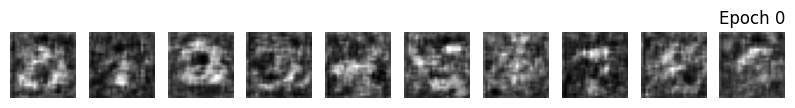

100%|██████████| 938/938 [00:30<00:00, 30.59it/s]


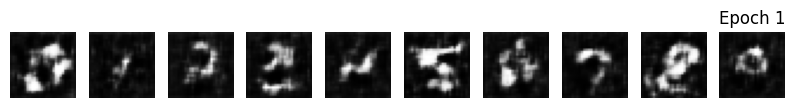

100%|██████████| 938/938 [00:30<00:00, 30.28it/s]


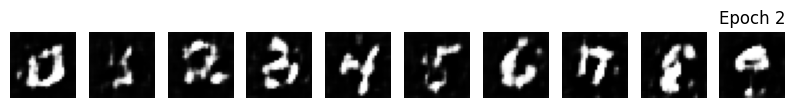

100%|██████████| 938/938 [00:30<00:00, 30.80it/s]


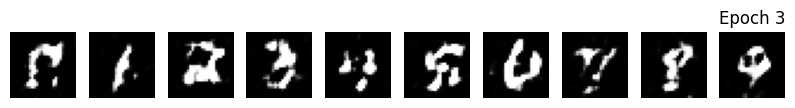

100%|██████████| 938/938 [00:31<00:00, 29.97it/s]


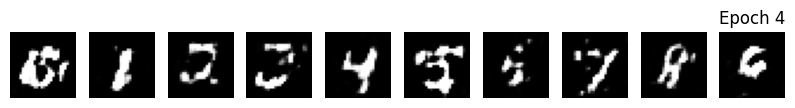

100%|██████████| 938/938 [00:30<00:00, 30.71it/s]


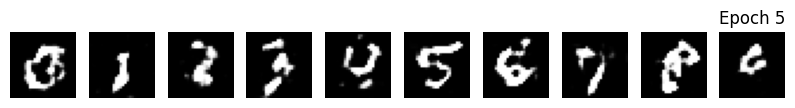

100%|██████████| 938/938 [00:31<00:00, 29.73it/s]


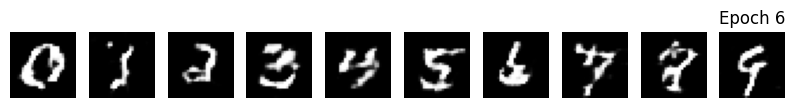

100%|██████████| 938/938 [00:29<00:00, 31.32it/s]


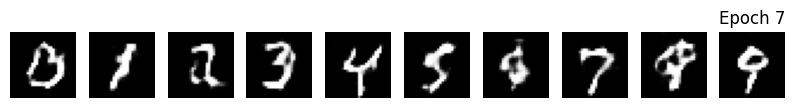

100%|██████████| 938/938 [00:33<00:00, 28.05it/s]


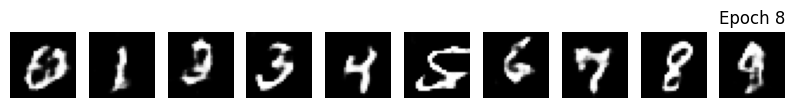

100%|██████████| 938/938 [00:31<00:00, 29.40it/s]


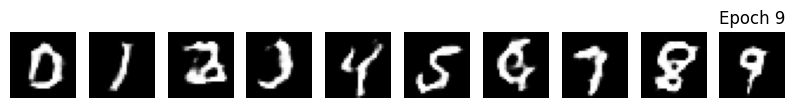

100%|██████████| 938/938 [00:31<00:00, 29.69it/s]


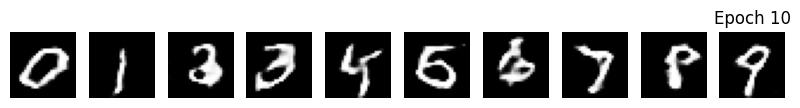

100%|██████████| 938/938 [00:32<00:00, 28.65it/s]


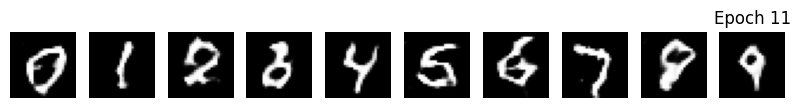

100%|██████████| 938/938 [00:31<00:00, 29.37it/s]


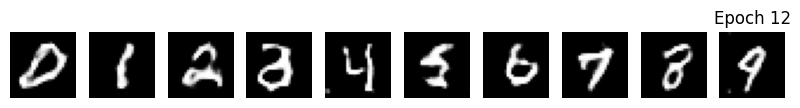

100%|██████████| 938/938 [00:31<00:00, 29.86it/s]


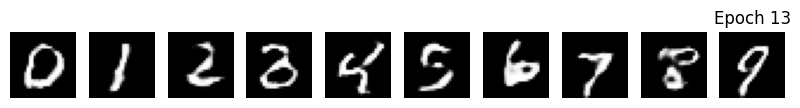

100%|██████████| 938/938 [00:33<00:00, 28.10it/s]


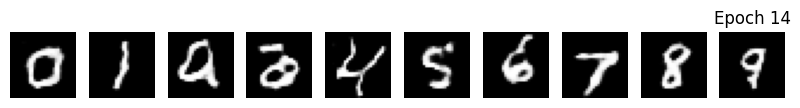

100%|██████████| 938/938 [00:32<00:00, 28.89it/s]


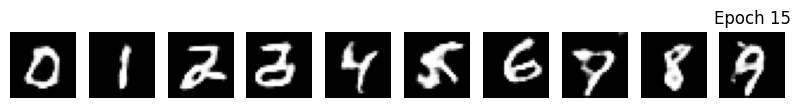

100%|██████████| 938/938 [00:31<00:00, 29.37it/s]


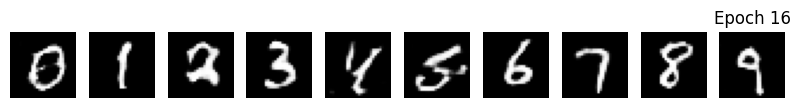

100%|██████████| 938/938 [00:33<00:00, 28.28it/s]


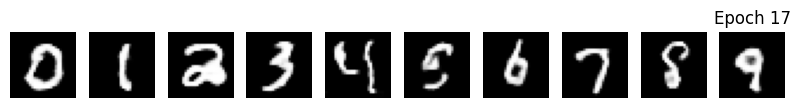

100%|██████████| 938/938 [00:32<00:00, 28.95it/s]


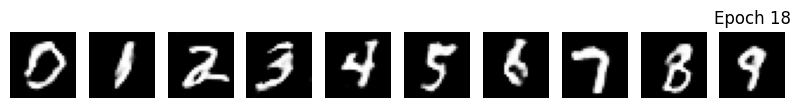

 52%|█████▏    | 491/938 [00:16<00:14, 30.50it/s]

In [ ]:
import matplotlib.pyplot as plt

train_dl = torch.utils.data.DataLoader(train_mnist, batch_size=64, shuffle=True)

generator = Generator(num_classes=10, latent_dim=128, output_dim=28).to("cuda")
discriminator = Discriminator(input_dim=28, num_classes=10).to("cuda")

generator_optimizer = torch.optim.Adam(generator.parameters(), lr=2e-4)
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=2e-4)

history = []
generator_snapshots = []

for epoch in range(0, 20):
    for real_images, real_classes in tqdm(train_dl):
        real_images = real_images.to("cuda")
        real_classes = real_classes.to("cuda")

        discriminator_optimizer.zero_grad()
        generator_optimizer.zero_grad()
        train_discriminator(
            generator=generator,
            discriminator=discriminator,
            optimizer=discriminator_optimizer,
            real_images=real_images,
            real_classes=real_classes
        )

        discriminator_optimizer.zero_grad()
        generator_optimizer.zero_grad()
        train_generator(
            generator=generator,
            discriminator=discriminator,
            optimizer=generator_optimizer,
            real_images=real_images
        )

    z = torch.randn(10, generator.latent_dim).to("cuda")
    c = torch.arange(0, 10).to("cuda")
    generated_images = generator(z, c)
    generated_images = denorm(generated_images)
    generated_images = generated_images.view(-1, 28, 28).detach().cpu().numpy()

    fig, axes = plt.subplots(1, 10, figsize=(10, 10))
    for i in range(10):
        axes[i].imshow(generated_images[i], cmap="gray")
        axes[i].set_axis_off()

    plt.title(f"Epoch {epoch}")
    plt.show()

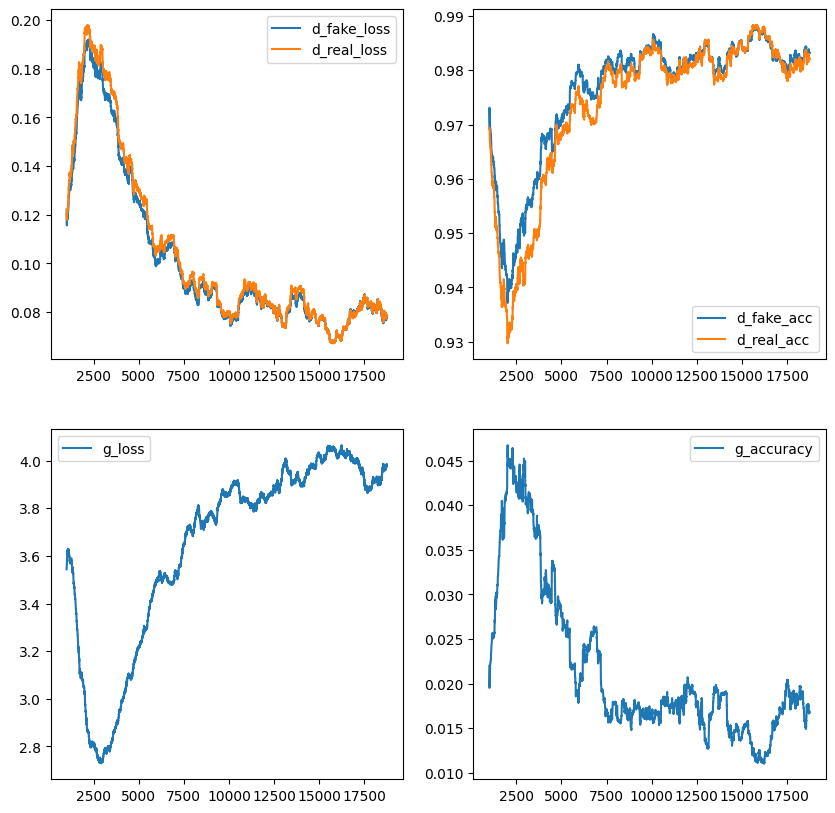

In [46]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame(history)
df = df.rolling(1000).mean()

fig, axes = plt.subplots(2, 2, figsize=(10, 10))

df.plot(y=["d_fake_loss", "d_real_loss"], ax=axes[0, 0])
df.plot(y=["d_fake_acc", "d_real_acc"], ax=axes[0, 1])
df.plot(y=["g_loss"], ax=axes[1, 0])
df.plot(y=["g_accuracy"], ax=axes[1, 1])

plt.show()